# A FeedForward Deep Neural Network on the FashionMnist Dataset
> This notebook is one of the contributions made to the MODECI-MDF project for Outreachy Internship Contribution Phase (Summer, 2023) . The aim of creating this notebook is to build a model using pytorch and convert the model to MDF model using the `pytorch_to_mdf` function developed by MODECI

Workflow:
1. Get the FashionMNIST dataset available in torchvision datasets as;
    - Train image data
    - Test image data
2. Preprocess the image data
    - create shuffled batches of the train data as tensors. Normalized to 0 -1.
3. Create PyTorch Model
    - Create a feedforward neural network using `nn.Module` which is pytorch's base class for building neural nets
    - Train the network on the train data
    - Evaluate the network on the test data
    - Get the result of prediction on one of the test images 
4. Create MDF Model
    - Use the pytorch_to_mdf function to create MDF model from the pytorch model and the test image whose result was accessed
    - Visualize mdf graph
    - Assert the results are the same for pytorch and mdf
5. Create ONNX graph from pytorch model

## Reference

This notebook was created using concepts and structures learnt from taking Datacamp's Course on **[Deep Learning with PyTorch](https://campus.datacamp.com/courses/deep-learning-with-pytorch/introduction-to-pytorch?ex=1)**
to gain an understanding on how to preprocess data in pytorch and build neural networks using pytorch.

The course showed how to build feedforward network and convolutional network using the `MNIST` dataset. A lot of the concepts and structure used here was in accordance with how the [course on feedforward network](https://campus.datacamp.com/courses/deep-learning-with-pytorch/artificial-neural-networks?ex=1) was taught on pytorch. 

Implementation done here that differed from the course are as follows:
- Use of different dataset (fashion-mnist instead of mnist and cifar-10)
- Data Transformation
    - In the course data was normalized using the mean and standard deviation after scaling the tensor values in 0-1
    - In this notebook normalization was not done but the tensor values were scaled to 0-1
    - The batch size used in the course was 32 but a batch_size of 10 was used here (each epochs had sample 10 images trained on 6000 times)
- Different architecture of feedforward network
    - The input shape defination in the course was different from what was done here
    - In the course the input was flattened before passing it as a parameter of the network
    - In this notebook the input was flattened after passing it in as a parameter of the network
    - In this notebook the predictions were appeneded to a list to compare with the mdf model predictions
    
    
    
**More references**:

[PyTorch Docs](https://pytorch.org/docs/stable/index.html)

[PyTorch Discussion](https://discuss.pytorch.org)

## Get and preprocess the Data

In [1]:
# import datasets module needed downloading the fashion-mnist data
import torchvision.datasets as datasets

# import transforms to preprocess the data
from torchvision import transforms

# download the training images, transform them to tensor, and rescale their pixel values to 0-1
train = datasets.FashionMNIST(root=".", download=True, train=True, transform = transforms.ToTensor())

# download the test images, transform them to tensor and rescale their pixel values to 0-1
test = datasets.FashionMNIST(root=".", download=True, train=False, transform = transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw



In [2]:
from torch.utils.data import DataLoader

# load the train data
train_dl = DataLoader(train, batch_size=10, shuffle=True)

# load the test data
test_dl = DataLoader(test, batch_size=10, shuffle=False)

In [3]:
# inspect the train and test data loader
# get the shape of the training set and test data set
train_dl_shape = train_dl.dataset.data.shape
test_dl_shape = test_dl.dataset.data.shape

# print the shapes
print(f"train_dl_shape:\n{train_dl_shape}\n\ntest_dl_shape:\n{test_dl_shape}")

train_dl_shape:
torch.Size([60000, 28, 28])

test_dl_shape:
torch.Size([10000, 28, 28])


In [4]:
# create label index to name map
label_map = {0 : "T-shirt/top", 
             1 : "Trouser", 
             2 : "Pullover", 
             3 : "Dress", 
             4 : "Coat",
             5 : "Sandal",
             6 : "Shirt",
             7 : "Sneaker",
             8 : "Bag",
             9 : "Ankle boot"
            }

## PyTorch Model

### Building

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# create the network using the base class for all neural nets in pytorch
class FeedForwardNet(nn.Module):
  # calling the constructor of the parent class

    def __init__(self):
        super(FeedForwardNet, self).__init__()
        # define the layers for the network
        self.fc1 = nn.Linear(1*28*28, 256)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        
        # flatten the input data
        x = x.view(-1, 1*28*28)
        
        # create link between the layers and activation function
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Training 

In [6]:
# create an instance of the network
ff_model = FeedForwardNet()

# define the optimizer for the instance
optimizer = torch.optim.Adam(ff_model.parameters(), lr=0.001)

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the number of epochs
epochs = 4

# train the model for  epochs
for epoch in range(epochs):
    # loop through the batches generated by train_dl
    for idx, (x_train, y_train) in enumerate(train_dl):
        
        # do forward propagation
        y_pred = ff_model(x_train) # computed output
        loss = criterion(y_pred, y_train) # compute loss
        optimizer.zero_grad() # clear previous gradients 
        
        # do backward propagation 
        loss.backward() # get changes of weight and bias wrt to the loss
        optimizer.step() # updates the weight and bias
        
        # check epochs and losses for batches
        if (idx+1) % len(train_dl) == 0:
            batch = idx + 1
            print(f"Epochs {epoch+1}/{epochs}\n{batch}/{batch} - Loss: {round(loss.item(), 5)}")

Epochs 1/4
6000/6000 - Loss: 0.27108
Epochs 2/4
6000/6000 - Loss: 0.12072
Epochs 3/4
6000/6000 - Loss: 0.38017
Epochs 4/4
6000/6000 - Loss: 0.25044


### Validate

In [7]:
ff_model.eval()

FeedForwardNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
# Evaluate the ff_model on the test set
correct = 0 # current no of correct predictions 
total = 0# current total number of all predictions

predictions = list() # list to append prediction probabilities per batch
pred_probs = list() # list to append predictions per batch

with torch.no_grad():
    for x_test, y_test in test_dl:
        pred_prob = ff_model(x_test) # predicted probabilities for each batch 
        _, y_test_pred = torch.max(pred_prob.data, 1) # predicted label index
        total += y_test.size(0) # update total by number of mini-batch
        correct += (y_test_pred == y_test).sum().item()

        pred_probs.append(pred_prob)
        predictions.append(y_test_pred)

print(f'The model\'s accuracy on the test images is: {round((correct / total) * 100, 3)} %')

The model's accuracy on the test images is: 86.18 %


### Sample prediction on first Image in test set

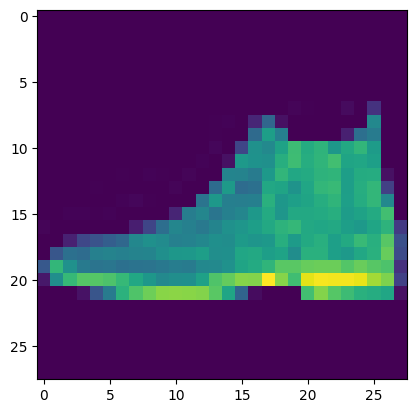

In [9]:
# visualize the image
import matplotlib.pyplot as plt
img_tensor = test.data[0] / 255

plt.imshow(img_tensor);

In [10]:
# check prediction probailities on first image in the test set
# do not compute gradient 
with torch.no_grad():
    sample_pred = ff_model(img_tensor)
sample_pred

tensor([[-11.6555, -17.1680, -13.6452, -18.5256, -15.4989,  -4.5574, -13.7593,
          -2.9831, -14.0825,   2.4066]])

In [11]:
# uncomment the code below to see another way of checking prediction probabilities on first image in the test set
# pred_probs[0][0]

In [12]:
# check predicted label name
label_idx = sample_pred.argmax()
print(f"This is a/an {label_map[label_idx.item()]}")

This is a/an Ankle boot


## MDF Model

In [13]:
# import packages needed for mdf model
from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

### Create MDF model

In [14]:
# convert pytorch model to mdf model
mdf_model, params_dict = pytorch_to_mdf(
        model=ff_model,
        args=img_tensor,
        trace=True,
    )

C:\Users\peaceOiza\Documents\mdf-env\lib\site-packages\torch\onnx\symbolic_helper.py:719: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")


### MDF Graph

Converting MDF graph: FeedForwardNetGraph to graphviz (level: 3, format: png)
    Node: Reshape_6
Converting .4 .3 .3 to hex color
Bkgd color: ['.4', '.3', '.3'] (#664c4c), font: white
    Node: Gemm_7
Converting .2 .3 .5 to hex color
Bkgd color: ['.2', '.3', '.5'] (#334c7f), font: white
    Node: Relu_8
Converting .4 .2 .1 to hex color
Bkgd color: ['.4', '.2', '.1'] (#663319), font: white
    Node: Gemm_9
Converting .2 .3 .5 to hex color
Bkgd color: ['.2', '.3', '.5'] (#334c7f), font: white
    Edge: Reshape_6_Gemm_7 connects Reshape_6 to Gemm_7
    Edge: Gemm_7_Relu_8 connects Gemm_7 to Relu_8
    Edge: Relu_8_Gemm_9 connects Relu_8 to Gemm_9
Written graph image to: pytorch_to_MDF.png


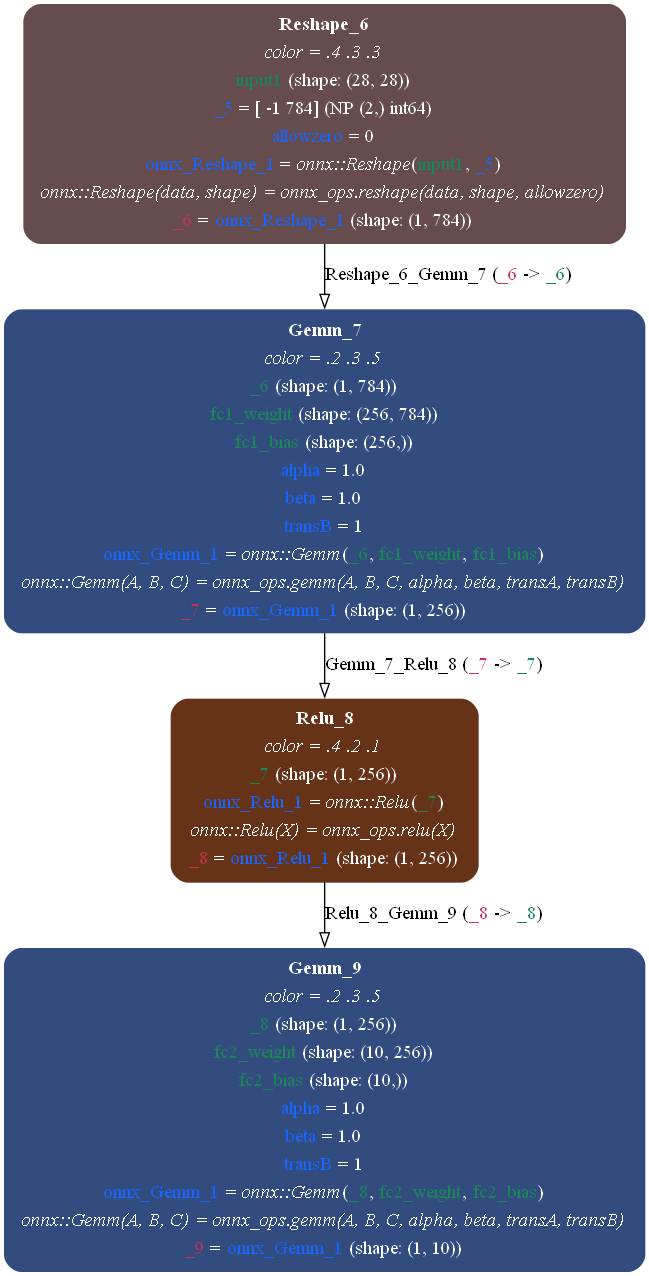

In [15]:
# visualize mdf-model graph image
mdf_model.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=3,
        filename_root="pytorch_to_MDF",
        is_horizontal=False,
        solid_color=True
)
from IPython.display import Image
Image(filename="pytorch_to_MDF.png")

In [16]:
# get the graph
mdf_graph = mdf_model.graphs[0]
params_dict["input1"] = img_tensor

# evaluate the graph
eg = EvaluableGraph(graph=mdf_graph, verbose=False)

eg.evaluate(initializer=params_dict)

# get mdf model prediction
mdf_pred = eg.output_enodes[0].get_output()
print(mdf_pred)
mdf_pred_idx = mdf_pred.argmax()
print(f"\nThis is a/an {label_map[mdf_pred_idx]}")


Init graph: FeedForwardNetGraph
Evaluating graph: FeedForwardNetGraph, root nodes: ['Reshape_6'], with array format numpy
[[-11.6554575  -17.16798019 -13.64522266 -18.5255661  -15.49886227
   -4.55735111 -13.75925159  -2.98314047 -14.0824995    2.40662003]]

This is a/an Ankle boot


In [17]:
# check the datatype of the mdf model prediction
mdf_pred.dtype

dtype('float64')

In [18]:
# check the datatype of the pytorch prediction
sample_pred.dtype

torch.float32

In [19]:
# create a variable to store mdf predictions with the same datatype as the pytorch prediction
mdf_pred_torch = torch.tensor(mdf_pred, dtype=torch.float32)
mdf_pred_torch

tensor([[-11.6555, -17.1680, -13.6452, -18.5256, -15.4989,  -4.5574, -13.7593,
          -2.9831, -14.0825,   2.4066]])

In [20]:
# compare the predictions of the pytorch model with the mdf model
torch.allclose(sample_pred, mdf_pred_torch)

True

## Onnx Graph from pytorch model

In [21]:
try:
    from IPython.display import Image
    onnx_graph = Image(filename="pytorch_to_MDF.onnx.png")
    display(onnx_graph)
    
except:
    import netron
    torch.onnx.export(
            ff_model,
            img_tensor,
            "pytorch_to_MDF.onnx",
            verbose=True,
            input_names=[],
            opset_version=9,
        )
    netron.start("pytorch_to_MDF.onnx")

graph(%0 : Float(28, 28, strides=[28, 1], requires_grad=0, device=cpu),
      %fc1.weight : Float(256, 784, strides=[784, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(10, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %5 : Long(2, strides=[1], device=cpu) = onnx::Constant[value=  -1  784 [ CPULongType{2} ]]() # C:\Users\peaceOiza\AppData\Local\Temp\ipykernel_14032\3213453821.py:19:0
  %6 : Float(1, 784, strides=[784, 1], requires_grad=0, device=cpu) = onnx::Reshape(%0, %5) # C:\Users\peaceOiza\AppData\Local\Temp\ipykernel_14032\3213453821.py:19:0
  %7 : Float(1, 256, strides=[256, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%6, %fc1.weight, %fc1.bias) # C:\Users\peaceOiza\Documents\mdf-env\lib\site-packages\torch\nn\modules\linear.py:103:0
  %8 : Float(1, 256, strides=[256, 1], requires_grad